<a href="https://colab.research.google.com/github/chavgova/My-AI/blob/master/emotion_recognition_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT

In [2]:
#this is the copy of another projecct and ill make changes to see how i can make it better 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras import regularizers
import os

In [3]:
from google.colab import drive
import os

path = '/content/drive/My Drive/My_AI/RawData'

mylist = []
mylist = os.listdir(path)

print(mylist)	



['03-01-02-01-01-02-16.wav', '03-01-07-02-01-02-15.wav', '03-01-08-01-02-01-15.wav', '03-01-03-01-02-01-16.wav', '03-01-08-02-01-02-15.wav', '03-01-02-01-02-01-16.wav', '03-01-02-01-02-02-16.wav', '03-01-07-02-02-01-15.wav', '03-01-07-01-02-02-15.wav', '03-01-08-01-01-02-15.wav', '03-01-03-01-01-02-16.wav', '03-01-03-01-01-01-16.wav', '03-01-02-02-01-02-16.wav', '03-01-08-01-02-02-15.wav', '03-01-02-02-02-02-16.wav', '03-01-08-02-01-01-15.wav', '03-01-01-01-02-01-16.wav', '03-01-07-02-01-01-15.wav', '03-01-02-02-02-01-16.wav', '03-01-01-01-01-01-16.wav', '03-01-08-02-02-02-15.wav', '03-01-02-02-01-01-16.wav', '03-01-06-02-01-02-15.wav', '03-01-08-02-02-01-15.wav', '03-01-01-01-01-02-16.wav', '03-01-01-01-02-02-16.wav', '03-01-06-02-02-02-15.wav', '03-01-08-01-01-01-15.wav', '03-01-02-01-01-01-16.wav', '03-01-07-01-01-01-15.wav', '03-01-07-02-02-02-15.wav', '03-01-06-02-02-01-15.wav', '03-01-07-01-02-01-15.wav', '03-01-05-02-02-01-16.wav', '03-01-04-01-01-02-16.wav', '03-01-06-01-01-02-

In [4]:
print(mylist[50])

03-01-06-01-02-01-16.wav


In [5]:
print(mylist[18][6:-16])

02


LABLES

In [6]:
feeling_list=[]
for item in mylist:
    if int(item[18:-4])%2==0:  #female
        if item[6:-16]=='01':
          feeling_list.append('female_neutral')
        elif item[6:-16]=='02':
          feeling_list.append('female_calm')
        elif item[6:-16]=='03':
          feeling_list.append('female_happy')
        elif item[6:-16]=='04':
          feeling_list.append('female_sad')
        elif item[6:-16]=='05':
          feeling_list.append('female_angry')
        elif item[6:-16]=='06':
          feeling_list.append('female_fearful')
        elif item[6:-16]=='07':
          feeling_list.append('female_disgust')
        elif item[6:-16]=='08':
          feeling_list.append('female_surprised')
    else:
      if item[6:-16]=='01':
        feeling_list.append('male_neutral')
      elif item[6:-16]=='02':
        feeling_list.append('male_calm')
      elif item[6:-16]=='03':
        feeling_list.append('male_happy')
      elif item[6:-16]=='04':
        feeling_list.append('male_sad')
      elif item[6:-16]=='05':
        feeling_list.append('male_angry')
      elif item[6:-16]=='06':
        feeling_list.append('male_fearful')
      elif item[6:-16]=='07':
        feeling_list.append('male_disgust')
      elif item[6:-16]=='08':
        feeling_list.append('male_surprised')


In [7]:
import pandas as pd

labels = pd.DataFrame(feeling_list)
labels[:10]      #print

,0
0,female_calm
1,male_disgust
2,male_surprised
3,female_happy
4,male_surprised
5,female_calm
6,female_calm
7,male_disgust
8,male_disgust
9,male_surprised


Getting the features of audio files using librosa

In [8]:
import librosa
import numpy as np

def extract_feature(my_file, **kwargs):
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    X, sample_rate = librosa.core.load(my_file)
    if chroma or contrast:
        stft = np.abs(librosa.stft(X))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))  # 40 values 
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, chroma))  # 12 values 
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result = np.hstack((result, mel))  # 128 values 
    if contrast:
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, contrast)) # 7 values 
    if tonnetz:
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
        result = np.hstack((result, tonnetz)) # 6 values 

    return result

f = os.fspath('/content/drive/My Drive/My_AI/RawData/03-01-08-01-01-02-01.wav')
a = extract_feature(f, mel=True, mfcc=True, contrast=True, chroma=True, tonnetz=True)
print(a, a.shape)

[-6.84004989e+02  5.32450840e+01 -3.82405212e+00  1.08633848e+01
  6.45998657e+00 -1.76418794e+00 -6.69027890e+00 -5.71296504e+00
 -1.02703711e+01 -1.24663496e+00 -1.42016495e+00 -5.53884220e+00
 -7.63195972e-01 -4.26062887e+00 -5.46744871e+00  1.86795079e+00
 -6.22305035e+00 -2.08268366e+00 -3.65107353e-01 -7.48533222e-01
 -6.96590727e+00 -1.44718670e+00 -3.59923825e+00 -3.56393090e+00
 -2.77594965e+00 -2.98965773e+00 -3.82198522e+00 -1.49731349e+00
 -2.70504382e+00 -1.32901307e+00 -1.88366352e+00 -1.73925725e+00
 -2.15880931e+00 -1.87022926e+00 -3.57598030e+00 -1.49111468e+00
 -2.10047279e+00 -8.99386099e-01 -2.84401069e+00 -2.30541155e+00
  7.80550834e-01  8.00080035e-01  8.01224957e-01  7.54025271e-01
  6.85943634e-01  6.71676561e-01  7.43009431e-01  7.71004724e-01
  7.46792360e-01  7.60950897e-01  7.62073349e-01  7.73509293e-01
  5.42677068e-06  3.91708064e-05  1.58175380e-03  1.92751743e-02
  6.36823604e-02  3.66249441e-02  5.73856774e-03  6.86588743e-03
  2.90028191e-02  7.74857

In [9]:
data_frame = pd.DataFrame(columns=['all_features'])
bookmark=0

#mylist = mylist[:100]
for index,y in enumerate(mylist):
      all_features_ndarray = extract_feature('/content/drive/My Drive/My_AI/RawData/'+y, mel=True, mfcc=True, contrast=True, chroma=True, tonnetz=True)
      data_frame.loc[bookmark] = [all_features_ndarray]
      bookmark=bookmark+1
        
#df[:5]    #print 


In [10]:
data_frame[:5]

,all_features
0,"[-647.8555471119504, 55.16197404864515, 6.0226..."
1,"[-563.9630673729479, 84.1889432627838, -3.1524..."
2,"[-594.637782525203, 67.32199766509768, -8.2687..."
3,"[-579.8911360444731, 42.03962718331092, -5.053..."
4,"[-565.4067555993915, 62.30382942234893, -5.321..."


In [11]:
data_frame = pd.DataFrame(data_frame['all_features'].values.tolist())
data_frame[:10]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192
0,-647.855547,55.161974,6.022664,11.279636,1.494477,-10.823069,-9.768314,-3.426524,-5.141561,-3.937714,-9.222471,-2.322059,-3.491471,-3.229235,-2.588595,-6.148681,-4.438408,-3.765655,-6.711987,-2.241300,-5.629476,-3.342788,-5.519323,-2.143104,-3.962271,0.580401,-0.845263,0.836235,-1.663852,0.103594,-1.442232,2.398137,1.210933,1.309208,-1.149667,0.796317,-0.387185,1.851878,1.965089,2.852826,...,0.000026,0.000028,0.000056,0.000062,0.000073,0.000086,0.000148,0.000405,0.000204,0.000275,0.000194,0.000097,0.000089,0.000097,0.000078,0.000133,0.000146,0.000158,0.000236,0.000160,0.000115,0.000124,0.000239,0.000243,0.000193,0.000037,4.089572e-06,19.825734,17.413286,18.683788,17.631371,17.597609,17.479021,27.669175,0.008979,0.002485,-0.011113,0.007860,-0.022812,0.010703
1,-563.963067,84.188943,-3.152482,14.670623,14.059518,1.252880,0.042044,-4.397226,-4.238579,4.932143,4.076926,4.698377,2.391880,3.431389,2.035749,4.756171,2.224375,1.005362,4.411248,3.984690,-0.575655,5.080584,1.983271,6.256003,0.638210,3.379015,1.574879,5.086869,-0.242717,3.516233,2.506099,4.326962,3.277128,3.450532,1.574356,5.171896,1.693470,1.381288,0.377714,0.676257,...,0.000180,0.000131,0.000161,0.000127,0.000110,0.000103,0.000081,0.000054,0.000073,0.000041,0.000052,0.000044,0.000038,0.000035,0.000044,0.000065,0.000059,0.000042,0.000044,0.000062,0.000066,0.000068,0.000047,0.000039,0.000038,0.000023,2.302145e-06,23.765040,14.047504,17.620982,16.756985,18.187620,18.827449,29.978436,-0.033824,0.031722,-0.020895,0.045294,0.001301,0.021214
2,-594.637783,67.321998,-8.268769,11.827235,11.677641,-2.248863,-0.757726,-1.896019,-6.689641,2.705992,1.314382,1.545111,-2.906595,1.502054,2.958313,1.123918,0.773195,-2.079359,-0.045413,-0.557165,-4.386110,0.844472,-1.391011,-0.348034,-2.591043,2.353713,-1.338228,2.886713,-1.977508,3.363003,1.152010,1.973229,0.534796,1.680699,-0.927337,2.229836,-1.213668,0.681434,-0.775523,-0.460335,...,0.000127,0.000236,0.000162,0.000102,0.000152,0.000227,0.000257,0.000131,0.000087,0.000106,0.000106,0.000104,0.000086,0.000044,0.000047,0.000054,0.000035,0.000028,0.000023,0.000019,0.000029,0.000032,0.000036,0.000037,0.000031,0.000011,7.863616e-07,19.929019,14.123903,15.800768,15.526285,16.498655,18.605405,29.240658,-0.004248,0.026129,-0.065590,-0.075824,0.024136,0.000908
3,-579.891136,42.039627,-5.053938,7.798847,-0.126285,-9.143354,-12.422559,-8.201250,-6.497337,-1.633368,-9.284363,-4.746703,-2.252793,-5.042223,-4.782923,-4.012217,-5.518520,-4.907112,-4.995540,-4.075550,-5.216173,-5.194875,-4.929390,-4.127506,-6.202564,-0.801092,-1.592606,2.628457,-0.227953,1.161160,-3.117599,-1.825591,-3.542235,-0.268574,0.695758,5.276096,4.330442,3.046888,0.705429,0.176194,...,0.000562,0.000343,0.000465,0.000726,0.000588,0.000524,0.000399,0.000546,0.000814,0.000702,0.000639,0.000532,0.001084,0.000709,0.000725,0.000817,0.000606,0.000388,0.000592,0.001056,0.001199,0.001075,0.001202,0.000646,0.000797,0.000216,8.414706e-06,21.887936,17.434534,18.300346,15.796353,16.286331,17.025731,29.803272,0.004377,0.022846,0.011245,0.010188,0.004092,0.014409
4,-565.406756,62.303829,-5.321900,18.836435,15.299373,-2.065662,2.862254,1.808206,-3.145949,5.947861,2.749695,1.463870,0.905952,4.024624,3.162084,2.127669,2.406441,-2.238956,1.615928,2.867413,-2.066120,3.500315,-0.105012,3.404132,-0.740987,2.726745,-1.422287,2.922709,-1.661077,2.871916,1.522402,1.949224,0.923216,0.273763,-0.487322,2.254013,0.374031,2.177778,1.066371,1.301072,...,0.000050,0.000052,0.000075,0.000091,0.000066,0.000046,0.000037,0.000070,0.000070,0.000065,0.000086,0.000108,0.000078,0.000063,0.000041,0.000030,0.000023,0.000021,0.000036,0.000049,0.000060,0.000055,0.000069,0.000078,0.000042,0.000021,1.715290e-06,21.130542,12.441178,15.138805,14.482804,

In [12]:
data_frame_labels = pd.concat([data_frame,labels], axis=1)
data_frame_labels = data_frame_labels.rename(index=str, columns={"0": "label"})
data_frame_labels[:10]     #print

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,0
0,-647.855547,55.161974,6.022664,11.279636,1.494477,-10.823069,-9.768314,-3.426524,-5.141561,-3.937714,-9.222471,-2.322059,-3.491471,-3.229235,-2.588595,-6.148681,-4.438408,-3.765655,-6.711987,-2.241300,-5.629476,-3.342788,-5.519323,-2.143104,-3.962271,0.580401,-0.845263,0.836235,-1.663852,0.103594,-1.442232,2.398137,1.210933,1.309208,-1.149667,0.796317,-0.387185,1.851878,1.965089,2.852826,...,0.000028,0.000056,0.000062,0.000073,0.000086,0.000148,0.000405,0.000204,0.000275,0.000194,0.000097,0.000089,0.000097,0.000078,0.000133,0.000146,0.000158,0.000236,0.000160,0.000115,0.000124,0.000239,0.000243,0.000193,0.000037,4.089572e-06,19.825734,17.413286,18.683788,17.631371,17.597609,17.479021,27.669175,0.008979,0.002485,-0.011113,0.007860,-0.022812,0.010703,female_calm
1,-563.963067,84.188943,-3.152482,14.670623,14.059518,1.252880,0.042044,-4.397226,-4.238579,4.932143,4.076926,4.698377,2.391880,3.431389,2.035749,4.756171,2.224375,1.005362,4.411248,3.984690,-0.575655,5.080584,1.983271,6.256003,0.638210,3.379015,1.574879,5.086869,-0.242717,3.516233,2.506099,4.326962,3.277128,3.450532,1.574356,5.171896,1.693470,1.381288,0.377714,0.676257,...,0.000131,0.000161,0.000127,0.000110,0.000103,0.000081,0.000054,0.000073,0.000041,0.000052,0.000044,0.000038,0.000035,0.000044,0.000065,0.000059,0.000042,0.000044,0.000062,0.000066,0.000068,0.000047,0.000039,0.000038,0.000023,2.302145e-06,23.765040,14.047504,17.620982,16.756985,18.187620,18.827449,29.978436,-0.033824,0.031722,-0.020895,0.045294,0.001301,0.021214,male_disgust
2,-594.637783,67.321998,-8.268769,11.827235,11.677641,-2.248863,-0.757726,-1.896019,-6.689641,2.705992,1.314382,1.545111,-2.906595,1.502054,2.958313,1.123918,0.773195,-2.079359,-0.045413,-0.557165,-4.386110,0.844472,-1.391011,-0.348034,-2.591043,2.353713,-1.338228,2.886713,-1.977508,3.363003,1.152010,1.973229,0.534796,1.680699,-0.927337,2.229836,-1.213668,0.681434,-0.775523,-0.460335,...,0.000236,0.000162,0.000102,0.000152,0.000227,0.000257,0.000131,0.000087,0.000106,0.000106,0.000104,0.000086,0.000044,0.000047,0.000054,0.000035,0.000028,0.000023,0.000019,0.000029,0.000032,0.000036,0.000037,0.000031,0.000011,7.863616e-07,19.929019,14.123903,15.800768,15.526285,16.498655,18.605405,29.240658,-0.004248,0.026129,-0.065590,-0.075824,0.024136,0.000908,male_surprised
3,-579.891136,42.039627,-5.053938,7.798847,-0.126285,-9.143354,-12.422559,-8.201250,-6.497337,-1.633368,-9.284363,-4.746703,-2.252793,-5.042223,-4.782923,-4.012217,-5.518520,-4.907112,-4.995540,-4.075550,-5.216173,-5.194875,-4.929390,-4.127506,-6.202564,-0.801092,-1.592606,2.628457,-0.227953,1.161160,-3.117599,-1.825591,-3.542235,-0.268574,0.695758,5.276096,4.330442,3.046888,0.705429,0.176194,...,0.000343,0.000465,0.000726,0.000588,0.000524,0.000399,0.000546,0.000814,0.000702,0.000639,0.000532,0.001084,0.000709,0.000725,0.000817,0.000606,0.000388,0.000592,0.001056,0.001199,0.001075,0.001202,0.000646,0.000797,0.000216,8.414706e-06,21.887936,17.434534,18.300346,15.796353,16.286331,17.025731,29.803272,0.004377,0.022846,0.011245,0.010188,0.004092,0.014409,female_happy
4,-565.406756,62.303829,-5.321900,18.836435,15.299373,-2.065662,2.862254,1.808206,-3.145949,5.947861,2.749695,1.463870,0.905952,4.024624,3.162084,2.127669,2.406441,-2.238956,1.615928,2.867413,-2.066120,3.500315,-0.105012,3.404132,-0.740987,2.726745,-1.422287,2.922709,-1.661077,2.871916,1.522402,1.949224,0.923216,0.273763,-0.487322,2.254013,0.374031,2.177778,1.066371,1.301072,...,0.000052,0.000075,0.000091,0.000066,0.000046,0.000037,0.000070,0.000070,0.000065,0.000086,0.000108,0.000078,0.000063,0.000041,0.000030,0.000023,0.000021,0.000036,0.000049,0.000060,0.000055,0.000069,0.000078,0.000042,0.000021,1.715290e-06,21.130542,12.441178,15.138805,14.4

In [13]:
from sklearn.utils import shuffle
data_frame_labels = shuffle(data_frame_labels)
data_frame_labels[:10]      #print 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,0
775,-396.396640,27.030175,-26.552244,-8.632350,-6.580234,-10.693038,-7.082602,-12.260193,-12.373375,2.002265,-6.224712,1.043583,4.288108,14.713414,15.212629,7.501477,1.931863,6.697735,0.383086,4.438645,0.916065,1.958331,-1.714824,2.236084,-1.154788,3.694123,3.650606,4.404525,0.890125,6.318866,6.613082,4.701779,1.005672,2.137041,2.740155,3.488728,1.874016,4.674108,1.648596,2.010281,...,0.001907,0.001484,0.001730,1.483734e-03,0.001986,0.001492,0.001500,0.002309,0.002952,0.003420,0.002778,0.001759,0.001766,0.001404,0.001355,0.001213,0.001440,0.001978,0.001932,0.001748,0.001336,0.001410,0.001414,0.001289,5.223861e-04,4.167095e-05,21.470801,14.619874,19.597280,18.285673,18.914049,17.969113,29.106494,-0.009192,0.026874,-0.005415,0.002319,0.004421,0.008883,female_fearful
919,-589.439659,55.169508,8.935393,13.541853,13.427792,5.947900,0.114994,-3.064199,1.441267,6.291449,0.048298,2.165928,3.280590,3.484210,1.771395,1.067093,-0.175325,1.618100,-0.372802,-0.573905,-2.670994,2.905886,-2.629027,0.348750,-1.101078,1.048441,-1.864348,2.473260,-3.759977,2.162648,0.111734,1.240744,0.053949,1.141032,-0.343517,2.375947,0.500379,0.019817,0.173350,0.301453,...,0.000565,0.000535,0.000376,3.908774e-04,0.000470,0.000367,0.000325,0.000237,0.000182,0.000205,0.000277,0.000339,0.000446,0.000384,0.000289,0.000217,0.000123,0.000197,0.000339,0.000377,0.000465,0.000608,0.000741,0.000698,2.468051e-04,2.300903e-05,22.025806,13.025885,15.286845,14.476047,16.317203,16.187860,29.685559,-0.011365,0.059705,-0.044689,-0.004440,0.000706,0.023335,male_fearful
542,-752.713037,73.308613,15.784313,21.179825,11.996756,9.870913,-2.683460,-3.170570,-0.623198,3.163616,-7.862445,5.047666,0.151268,-0.716996,-0.497822,3.090362,-0.542775,1.804272,-5.021500,3.208506,-0.970868,-1.535484,-5.072687,-0.337100,-3.233162,0.887993,-1.996446,-0.589737,-1.359539,0.187367,-3.356380,0.608804,-2.753766,-0.734509,-2.087856,0.538833,-2.465359,-0.793090,-4.338124,-0.313061,...,0.000013,0.000013,0.000017,2.043815e-05,0.000017,0.000021,0.000015,0.000009,0.000010,0.000013,0.000007,0.000009,0.000012,0.000016,0.000016,0.000019,0.000016,0.000013,0.000011,0.000009,0.000006,0.000005,0.000003,0.000002,4.206747e-07,3.170348e-08,18.226531,13.088105,15.016846,13.771780,15.646609,15.263279,27.452480,0.005210,0.008796,0.000181,-0.027738,-0.000500,0.002996,male_calm
408,-684.487693,53.014396,-3.300337,8.046442,7.657967,0.567542,-1.203544,-3.704054,-9.161224,-3.371680,1.729762,-4.609501,-2.701942,0.085991,-3.205872,1.694154,-4.642064,-0.940206,-2.383624,-1.289258,-4.795285,-2.335876,-1.438397,-2.056738,-3.835851,-0.670626,-3.787016,-0.873376,-1.913669,-0.186351,-3.114970,-0.001548,-3.582352,-1.390925,-3.328647,-1.271135,-1.869478,-0.241554,-1.381260,-0.335485,...,0.000176,0.000157,0.000161,1.299126e-04,0.000087,0.000064,0.000068,0.000043,0.000033,0.000022,0.000023,0.000021,0.000029,0.000045,0.000027,0.000049,0.000045,0.000050,0.000038,0.000031,0.000026,0.000021,0.000035,0.000028,1.245931e-05,2.002966e-06,20.197704,12.576613,15.587151,14.479761,15.611967,16.017608,28.862152,-0.012091,0.036199,0.011498,0.034067,0.008919,0.027543,male_fearful
118,-700.476677,52.422657,-0.344908,12.032434,0.546657,-4.499004,0.869965,-13.109517,-4.833970,-2.754713,-2.180541,-5.419381,-6.125988,2.048518,-5.109396,-5.759003,-6.304673,-3.664168,-4.810129,-6.694475,-5.016166,-5.315120,-6.502347,-2.754897,-5.817794,-3.702186,-4.812328,-1.752812,-3.559843,2.337381,-2.782142,3.037440,0.916756,3.785304,-0.270782,2.138655,-0.405400,1.696937,2.630800,4.466392,...,0.000010,0.000013,0.000007,9.649559e-06,0.000005,0.000005,0.000007,0.000007,0.000006,0.000003,0.000006,0.000006,0.000006,0.000008,0.000011,0.000009,0.000007,0.000007,0.000009,0.000008,0.000010,0.000017,0.000017,0.

SAVE DATASET FEATURES AND LABELS 

In [14]:
import pickle

with open('/content/drive/My Drive/My_AI/dataset_features&labels.pkl', 'wb') as f:
  pickle.dump(data_frame_labels, f)


LOAD DATASET FEATURES AND LABELS 

In [15]:
with open('/content/drive/My Drive/My_AI/dataset_features&labels.pkl', 'rb') as f:
  data_frame_labels = pickle.load(f)


Dividing the data into test and train

In [16]:
data_frame_labels_set = np.random.rand(len(data_frame_labels)) < 0.8
train = data_frame_labels[data_frame_labels_set]
test = data_frame_labels[~data_frame_labels_set]

In [17]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,0
720,-562.926949,50.080369,9.655627,16.430141,2.536414,3.758323,2.239149,-0.851222,-6.689146,-1.092142,5.662221,-0.950982,-1.240816,1.203139,-0.188086,-0.879124,-1.315954,1.736917,0.031777,1.362387,-4.050894,0.835165,-1.930068,2.224790,-1.523802,-0.055618,-0.834375,2.382428,-0.569267,3.145042,1.985140,1.992095,0.265403,1.427646,-0.897406,2.523362,-0.038421,3.587232,1.241986,2.802326,...,0.001169,0.001117,0.001003,0.001396,0.001379,0.000879,0.000315,0.000453,0.000615,0.000650,0.000332,0.000283,0.000275,0.000251,0.000210,0.000180,0.000192,0.000236,0.000367,0.000379,0.000509,0.000603,0.000537,0.000377,0.000125,5.783631e-06,22.446425,14.667881,15.705274,14.681792,16.245583,15.853232,29.325059,-0.019103,0.029796,0.022175,-0.043326,-0.005901,0.012712,male_disgust
1240,-743.190239,54.139789,-3.050245,3.071649,1.561771,-8.520123,-13.646200,-10.976981,-6.058585,0.130015,-6.817773,-2.643620,-5.120786,-5.082862,-3.941372,-4.411242,-8.893342,-1.666233,-6.257990,-5.014346,-3.287184,-2.313442,-6.282532,-1.045335,-4.425191,0.685327,1.841720,9.849846,6.505461,10.111476,5.119269,9.928448,6.535774,9.583819,6.220580,3.625231,0.427104,1.652714,3.104750,6.310345,...,0.000023,0.000030,0.000039,0.000045,0.000029,0.000022,0.000021,0.000028,0.000016,0.000016,0.000012,0.000031,0.000022,0.000029,0.000041,0.000030,0.000030,0.000032,0.000026,0.000034,0.000085,0.000091,0.000064,0.000033,0.000010,5.388115e-07,17.705690,16.813611,17.947120,16.432092,17.449299,16.718030,29.006498,-0.019020,0.012237,-0.017736,-0.010005,-0.002094,0.006844,female_sad
141,-626.898001,38.645983,8.234060,-3.780172,-3.344736,-7.417803,1.684215,-13.702838,-10.406967,-6.313149,-9.702273,-5.800069,-8.358964,-3.103636,-4.792897,-5.210395,-5.417881,-5.318437,-6.863893,-2.665204,-3.988529,-3.715465,-2.992082,1.823155,-3.868195,-0.035510,-0.831905,2.157576,-1.617215,3.554040,-0.956763,1.703221,-1.121915,2.652540,0.563045,1.883394,1.347433,1.961402,0.294992,2.141956,...,0.000165,0.000170,0.000178,0.000219,0.000262,0.000206,0.000166,0.000213,0.000158,0.000101,0.000117,0.000135,0.000109,0.000202,0.000251,0.000424,0.000462,0.000634,0.001257,0.002363,0.001593,0.001126,0.000568,0.000412,0.000154,9.653324e-06,17.565355,14.162944,15.426194,13.832436,15.162791,16.335834,29.030984,-0.006440,0.011770,-0.017058,0.018111,0.003809,-0.000743,female_surprised
413,-530.964241,33.918575,-22.119224,6.214479,-10.779660,-14.865842,-6.799504,-10.370065,-6.132224,-2.574647,-9.840844,3.908191,-7.952865,-2.416503,0.797253,-8.005921,-2.882400,-2.324589,-4.930512,0.862421,-1.036260,0.792913,2.550171,4.557786,3.029042,4.331518,-1.082530,4.007406,1.772941,6.308486,7.147786,5.771718,0.921859,0.129351,0.441202,2.123073,-0.104114,-0.672019,-3.469128,0.510665,...,0.000342,0.000429,0.000367,0.000324,0.000215,0.000172,0.000240,0.000293,0.000414,0.000348,0.000433,0.000401,0.000315,0.000220,0.000266,0.000226,0.000153,0.000197,0.000206,0.000203,0.000161,0.000131,0.000134,0.000103,0.000040,3.580729e-06,14.557964,19.095337,18.938338,17.956438,17.959207,19.635195,29.157336,-0.012378,0.006740,-0.044830,0.028958,0.005110,-0.005492,female_happy
604,-555.729450,57.291489,-7.571409,6.819494,6.208236,-7.122828,-13.088510,-19.083521,-4.996963,0.521277,-2.847209,-3.391262,1.046310,1.808892,0.128943,4.780793,-6.009870,-2.275375,-1.479475,-6.709166,-3.139729,-2.121373,-6.797541,-0.501115,-3.779233,1.654836,1.346341,8.561809,5.841471,10.123738,6.494507,7.992269,7.345668,7.508685,2.620461,2.047119,-2.273666,1.870381,1.114411,2.273768,...,0.001552,0.000992,0.000629,0.000543,0.000326,0.000364,0.000204,0.000286,0.000298,0.000704,0.000535,0.000260,0.000191,0.000108,0.000140,0.000205,0.000202,0.000188,0.000114,0.000150,0.000170,0.000178,0.000175,0.000199,0.000063,5.161978e-06,17.

In [18]:
trainfeatures = train.iloc[:, :-1]
trainlabel = train.iloc[:, -1:]

In [19]:
testfeatures = test.iloc[:, :-1]
testlabel = test.iloc[:, -1:]

In [21]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [23]:
X_train.shape

(1039, 193)

Changing dimension for CNN model

In [24]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)
print(x_testcnn)

[[[-3.96396640e+02]
  [ 2.70301747e+01]
  [-2.65522436e+01]
  ...
  [ 2.31855054e-03]
  [ 4.42107764e-03]
  [ 8.88344241e-03]]

 [[-6.70492392e+02]
  [ 6.06987336e+01]
  [ 6.93785775e+00]
  ...
  [-2.25949009e-02]
  [ 1.23284185e-03]
  [ 8.72131406e-03]]

 [[-5.83441629e+02]
  [ 4.03382405e+01]
  [-2.13327197e+01]
  ...
  [-1.32780824e-02]
  [ 6.33317498e-03]
  [ 6.40984052e-03]]

 ...

 [[-4.50484397e+02]
  [ 2.24411998e+01]
  [-1.68054553e+01]
  ...
  [-9.04225514e-03]
  [ 1.48790868e-02]
  [ 2.05022997e-02]]

 [[-5.54773068e+02]
  [ 2.77833565e+01]
  [-1.42379608e+01]
  ...
  [-1.14719157e-02]
  [-3.57704941e-03]
  [-4.64172671e-03]]

 [[-5.37174998e+02]
  [ 2.64198226e+01]
  [-1.01328452e+01]
  ...
  [ 1.42131318e-02]
  [ 5.01925270e-03]
  [ 9.96504434e-03]]]


In [25]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(193,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))

model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(5))) #  was 8
#keras.layers.AveragePooling1D(pool_size = 8, strides=None, padding='valid', data_format='channels_last')
model.add(Dropout(0.1))

model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(16))
model.add(Activation('softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)  # new
#opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 193, 256)          1536      
_________________________________________________________________
activation (Activation)      (None, 193, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 193, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 193, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 193, 128)          82048     
_________________________________________________________________
activation_2 (Activation)    (None, 193, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 38, 128)           0

In [27]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

Removed the whole training part for avoiding unnecessary long epochs list

In [28]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=32, epochs=250, validation_data=(x_testcnn, y_test))

Epoch 1/250
33/33 [==============================] - 9s 281ms/step - loss: 2.7957 - accuracy: 0.0741 - val_loss: 2.7203 - val_accuracy: 0.1282
Epoch 2/250
33/33 [==============================] - 9s 278ms/step - loss: 2.6738 - accuracy: 0.1165 - val_loss: 2.6152 - val_accuracy: 0.1502
Epoch 3/250
33/33 [==============================] - 9s 281ms/step - loss: 2.5400 - accuracy: 0.1655 - val_loss: 2.4364 - val_accuracy: 0.2051
Epoch 4/250
33/33 [==============================] - 9s 288ms/step - loss: 2.3762 - accuracy: 0.2204 - val_loss: 2.2901 - val_accuracy: 0.2088
Epoch 5/250
33/33 [==============================] - 9s 271ms/step - loss: 2.2081 - accuracy: 0.2502 - val_loss: 2.1515 - val_accuracy: 0.2564
Epoch 6/250
33/33 [==============================] - 9s 280ms/step - loss: 2.1178 - accuracy: 0.2493 - val_loss: 2.0525 - val_accuracy: 0.2857
Epoch 7/250
33/33 [==============================] - 9s 270ms/step - loss: 2.0439 - accuracy: 0.2647 - val_loss: 2.0213 - val_accuracy: 0.2711

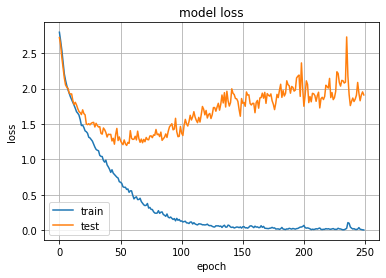

In [29]:
plt.figure()
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='lower left')
plt.show()

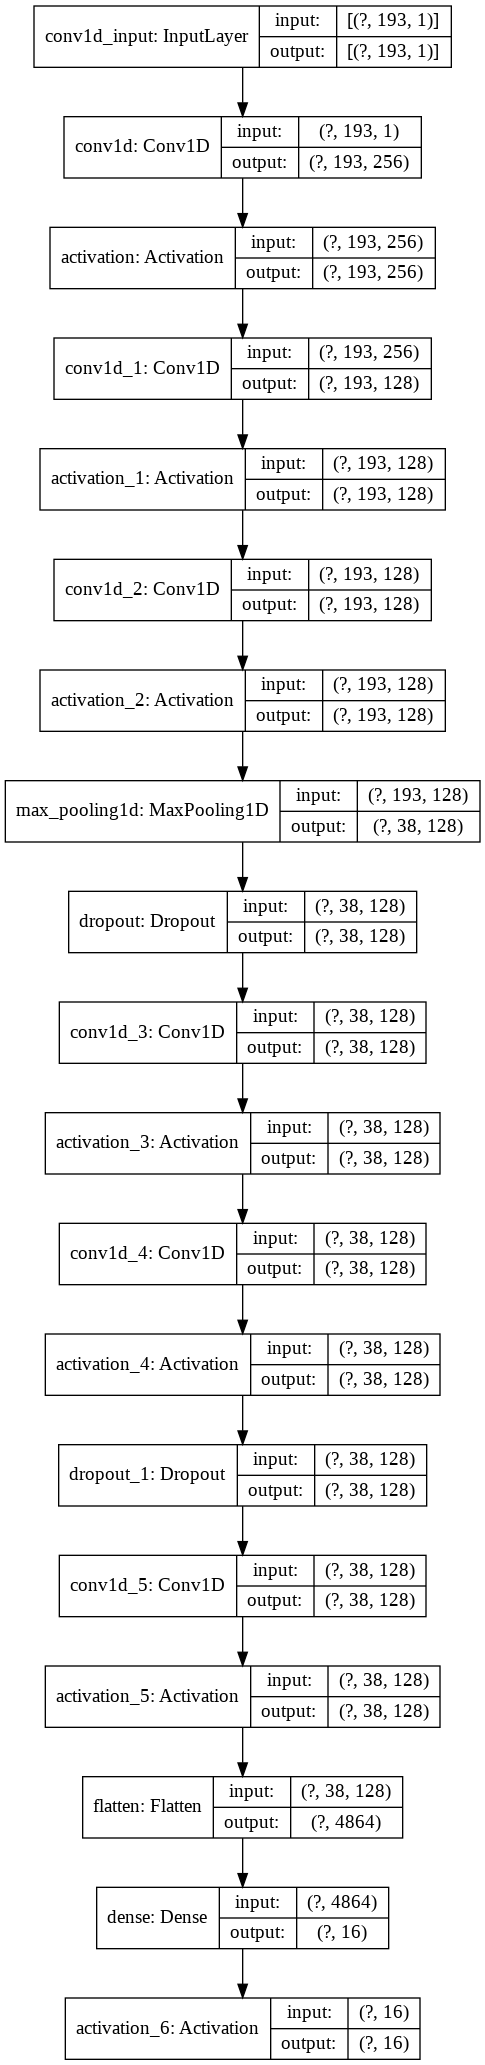

In [30]:
tf.keras.utils.plot_model(
    model,
    to_file="img_model.png",
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

dot_img_file = '/content/drive/My Drive/My_AI/img_model_05_opt.png'
tf.keras.utils.plot_model(model, to_file = dot_img_file, show_shapes=True)


SAVING THE MODEL

In [31]:
model_name = 'Emotion_Voice_Detection_CNN_model_05.h5'
path = '/content/drive/My Drive/My_AI/'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/Emotion_Voice_Detection_CNN_model_05.h5 


In [32]:
import json
model_json = model.to_json()
with open("/content/drive/My Drive/My_AI/Voice-Emotion-Detector-master/model_05.json", "w") as json_file:
    json_file.write(model_json)

LOADING THE MODEL

In [33]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('/content/drive/My Drive/My_AI/Voice-Emotion-Detector-master/model_05.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/saved_models/Emotion_Voice_Detection_CNN_model_05.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 73.99%


Predicting emotions on the test data

In [34]:
preds = loaded_model.predict(x_testcnn, batch_size=32, verbose=1)
preds1=preds.argmax(axis=1)

abc = preds1.astype(int).flatten()
predictions = (lb.inverse_transform((abc)))
preddf = pd.DataFrame({'predictedvalues': predictions})

actual=y_test.argmax(axis=1)

abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

actualdf = pd.DataFrame({'actualvalues': actualvalues})
finaldf = actualdf.join(preddf)

finaldf[10:20]

9/9 [==============================] - 1s 64ms/step


,actualvalues,predictedvalues
10,male_fearful,male_fearful
11,female_sad,female_calm
12,female_happy,female_happy
13,female_sad,female_sad
14,female_sad,female_sad
15,female_happy,female_happy
16,male_happy,male_disgust
17,female_fearful,male_fearful
18,male_sad,male_sad
19,female_happy,female_happy


In [35]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,15
female_calm,18
female_disgust,19
female_fearful,19
female_happy,17
female_neutral,9
female_sad,20
female_surprised,16
male_angry,18


In [36]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,18
female_calm,18
female_disgust,21
female_fearful,21
female_happy,18
female_neutral,12
female_sad,14
female_surprised,14
male_angry,24


In [37]:
finaldf.to_csv('Predictions.csv', index=False)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test', 'shuffle', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


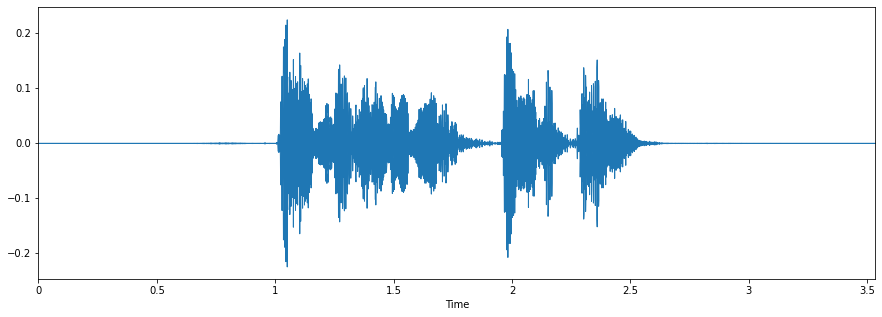

In [38]:
data, sampling_rate = librosa.load('/content/drive/My Drive/My_AI/RawData/03-01-08-02-02-02-21.wav')

% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [39]:
X, sample_rate = librosa.load('/content/drive/My Drive/My_AI/RawData/03-01-08-02-02-02-21.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)

demo_file = os.fspath('/content/drive/My Drive/My_AI/RawData/03-01-08-02-02-02-21.wav')
features_live  = extract_feature(demo_file, mel=True, mfcc=True, contrast=True, chroma=True, tonnetz=True)

In [40]:
features_live = pd.DataFrame(data = features_live)
features_live = features_live.stack().to_frame().T

In [41]:
features_live_2d = np.expand_dims(features_live, axis=2)
live_preds = loaded_model.predict(features_live_2d, batch_size=32, verbose=1)
live_preds = live_preds.argmax(axis=1)
live_preds = live_preds.astype(int).flatten()

live_preds = (lb.inverse_transform((live_preds)))
live_preds

1/1 [==============================] - 0s 1ms/step


array(['male_surprised'], dtype=object)